# Example:  Dentate Gyrus

The dataset used in here for velocity analysis is from the dentate gyrus, a part of the hippocampus which is involved in learning, episodic memory formation and spatial coding. It is measured using 10X Genomics Chromium and described in Hochgerner et al. (2018). The data consists of 25,919 genes across 3,396 cells and provides several interesting characteristics. 

We use a stochastic version of the model for transcriptional dynamics used in velocyto (developed by the Linnarsson lab and Kharchenko Lab).

RNA velocity reference https://www.nature.com/articles/s41586-018-0414-6 <br>
This notebook is based on http://pklab.med.harvard.edu/velocyto/notebooks/R/DG1.nb.html

Files needed: 10X43_1.loom (will be downloaded automatically) <br> 
Optional files: DG_umap.npy, DG_clusters.npy

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import scvelo as scv
scv.logging.print_version()

Running scvelo 0.1.16 on 2019-03-25 16:24.


We change the matplotlib defaults for beautified visualization.

In [2]:
scv.settings.set_figure_params('scvelo')

## Load and cleanup the data

Read your data file (loom, h5ad, xlsx, csv, tab, txt …) to an AnnData object.

If you want to merge your loom file into an already existing AnnData object, use `scv.utils.merge(adata, adata_loom)`.

In [4]:
adata = scv.read("data/DentateGyrus/10X43_1.loom", sparse=True, cache=True)

We have a first look into the proportions of spliced/unspliced abundances in our data.

Cleaning our data, i.e. throwing away everything not needed for velocity estimation, saves memory. This step is optional.

In [5]:
scv.utils.show_proportions(adata)
scv.utils.cleanup(adata, clean='all')

adata

Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.68 0.08 0.24]


AnnData object with n_obs × n_vars = 3396 × 25919 
    layers: 'spliced', 'unspliced'

## Preprocess the data

This selects genes by **detection** (detected with a minimum number of counts and expressed in a minimum number of cells) and **high variability** (dispersion).

It further **normalizes** every cell by its initial size and **logarithmizes** X.

X and the spliced/unspliced count data are preprocessed nearly in the same way (i.e. filtering and normalization), except that X is further logarithmized. Don't worry if X is already processed; it will detect that automatically and not touch X in that case.

If you want to run this step by step, you can do so with the following commands:
```
scv.pp.filter_genes(adata, min_counts=20, min_counts_u=10)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=3000)
scv.pp.log1p(adata)
```

In [6]:
scv.pp.filter_and_normalize(adata, min_counts=20, min_counts_u=10, n_top_genes=3000)

Filtered out 13864 genes that are detected in less than 20 counts (spliced).
Filtered out 6520 genes that are detected in less than 10 counts (unspliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


The first and second order moments (basically mean and uncentered variance) are computed among nearest neighbors in PCA space. The first order moments are needed for deterministic velocity estimation, stochastic estimation additionally requires the second order moments.

In [7]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:05.19) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00.64) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


## Compute velocity and velocity graph
The gene-specific velocities are obtained by fitting a ratio between precursor (unspliced) and mature (spliced) mRNA abundances that well explains the steady states (constant transcriptional state) and then computing the difference of the actual abundances with the abundances expected in the steady state.

By default the steady state is fitted using a simple linear (for deterministic approach) or generalized (for stochastic approach) regression. By setting the percentile `perc=95` you can perform an extreme quantile fit, that might better represent the steady states. Further you can set `fit_offset=True` to account for ambiguous reads that have not been assigned to unspliced or spliced. 

Every tool has its plotting counterpart. The results from `scv.tl.velocity`, for instance, can be visualized using `scv.pl.velocity`.

In [8]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00.55) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


This computes the (cosine) correlation of potential cell transitions with the velocity vector in high dimensional space.
The resulting velocity graph has dimension $n_{obs} \times n_{obs}$ and summarizes the possible cell state changes (given by a transition from one cell to another) that are well explained through the velocity vectors. If you set `approx=True` it is computed on a reduced PCA space with 50 components. 

The velocity graph can then be converted to a transition matrix by applying a Gaussian kernel on the cosine correlation which assigns high probabilities to cell state changes that correlate with the velocity vector. You can access the Markov transition matrix via `scv.tl.transition_matrix`. The resulting transition matrix can be used for a variety of applications shown hereinafter. For instance, it is used to place the velocities into a low-dimensional embedding by simply applying the mean transition with respect to the transition probabilities, i.e. `scv.tl.velocity_embedding`. Further, we can trace cells back along the Markov chain to their origins and potential fates, thus obtaining root cells and end points within a trajectory; via `scv.tl.terminal_states`.

In [9]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:05.25) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Project the velocity graph onto an embedding

This simply loads a UMAP embedding and annoted clusters that we have prepared for you. Alternatively, you can obtain an embedding and clustering yourself with `scv.tl.louvain(adata)` and `scv.tl.umap(adata)`.

In [22]:
url_data = 'https://github.com/theislab/scvelo_notebooks/raw/master/data/DentateGyrus/'

adata.obs['clusters'] = scv.load('./data/DentateGyrus/DG_clusters.npy', backup_url=url_data + 'DG_clusters.npy')
adata.obsm['X_umap'] = scv.load('./data/DentateGyrus/DG_umap.npy', backup_url=url_data + 'DG_umap.npy')

In [23]:
scv.tl.velocity_embedding(adata, basis='umap')

computing velocity embedding
    finished (0:00:00.82) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 700x500 with 0 Axes>

## Plot results

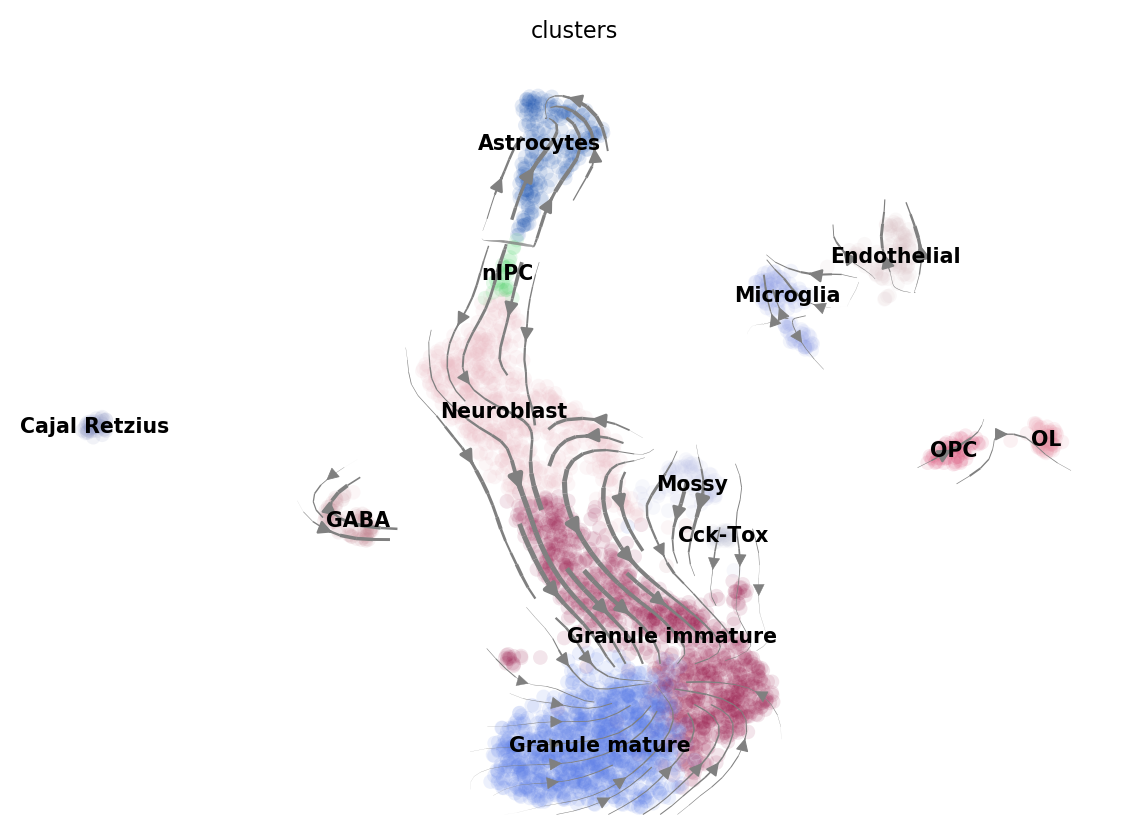

In [24]:
scv.pl.velocity_embedding_stream(adata, legend_loc='on data')

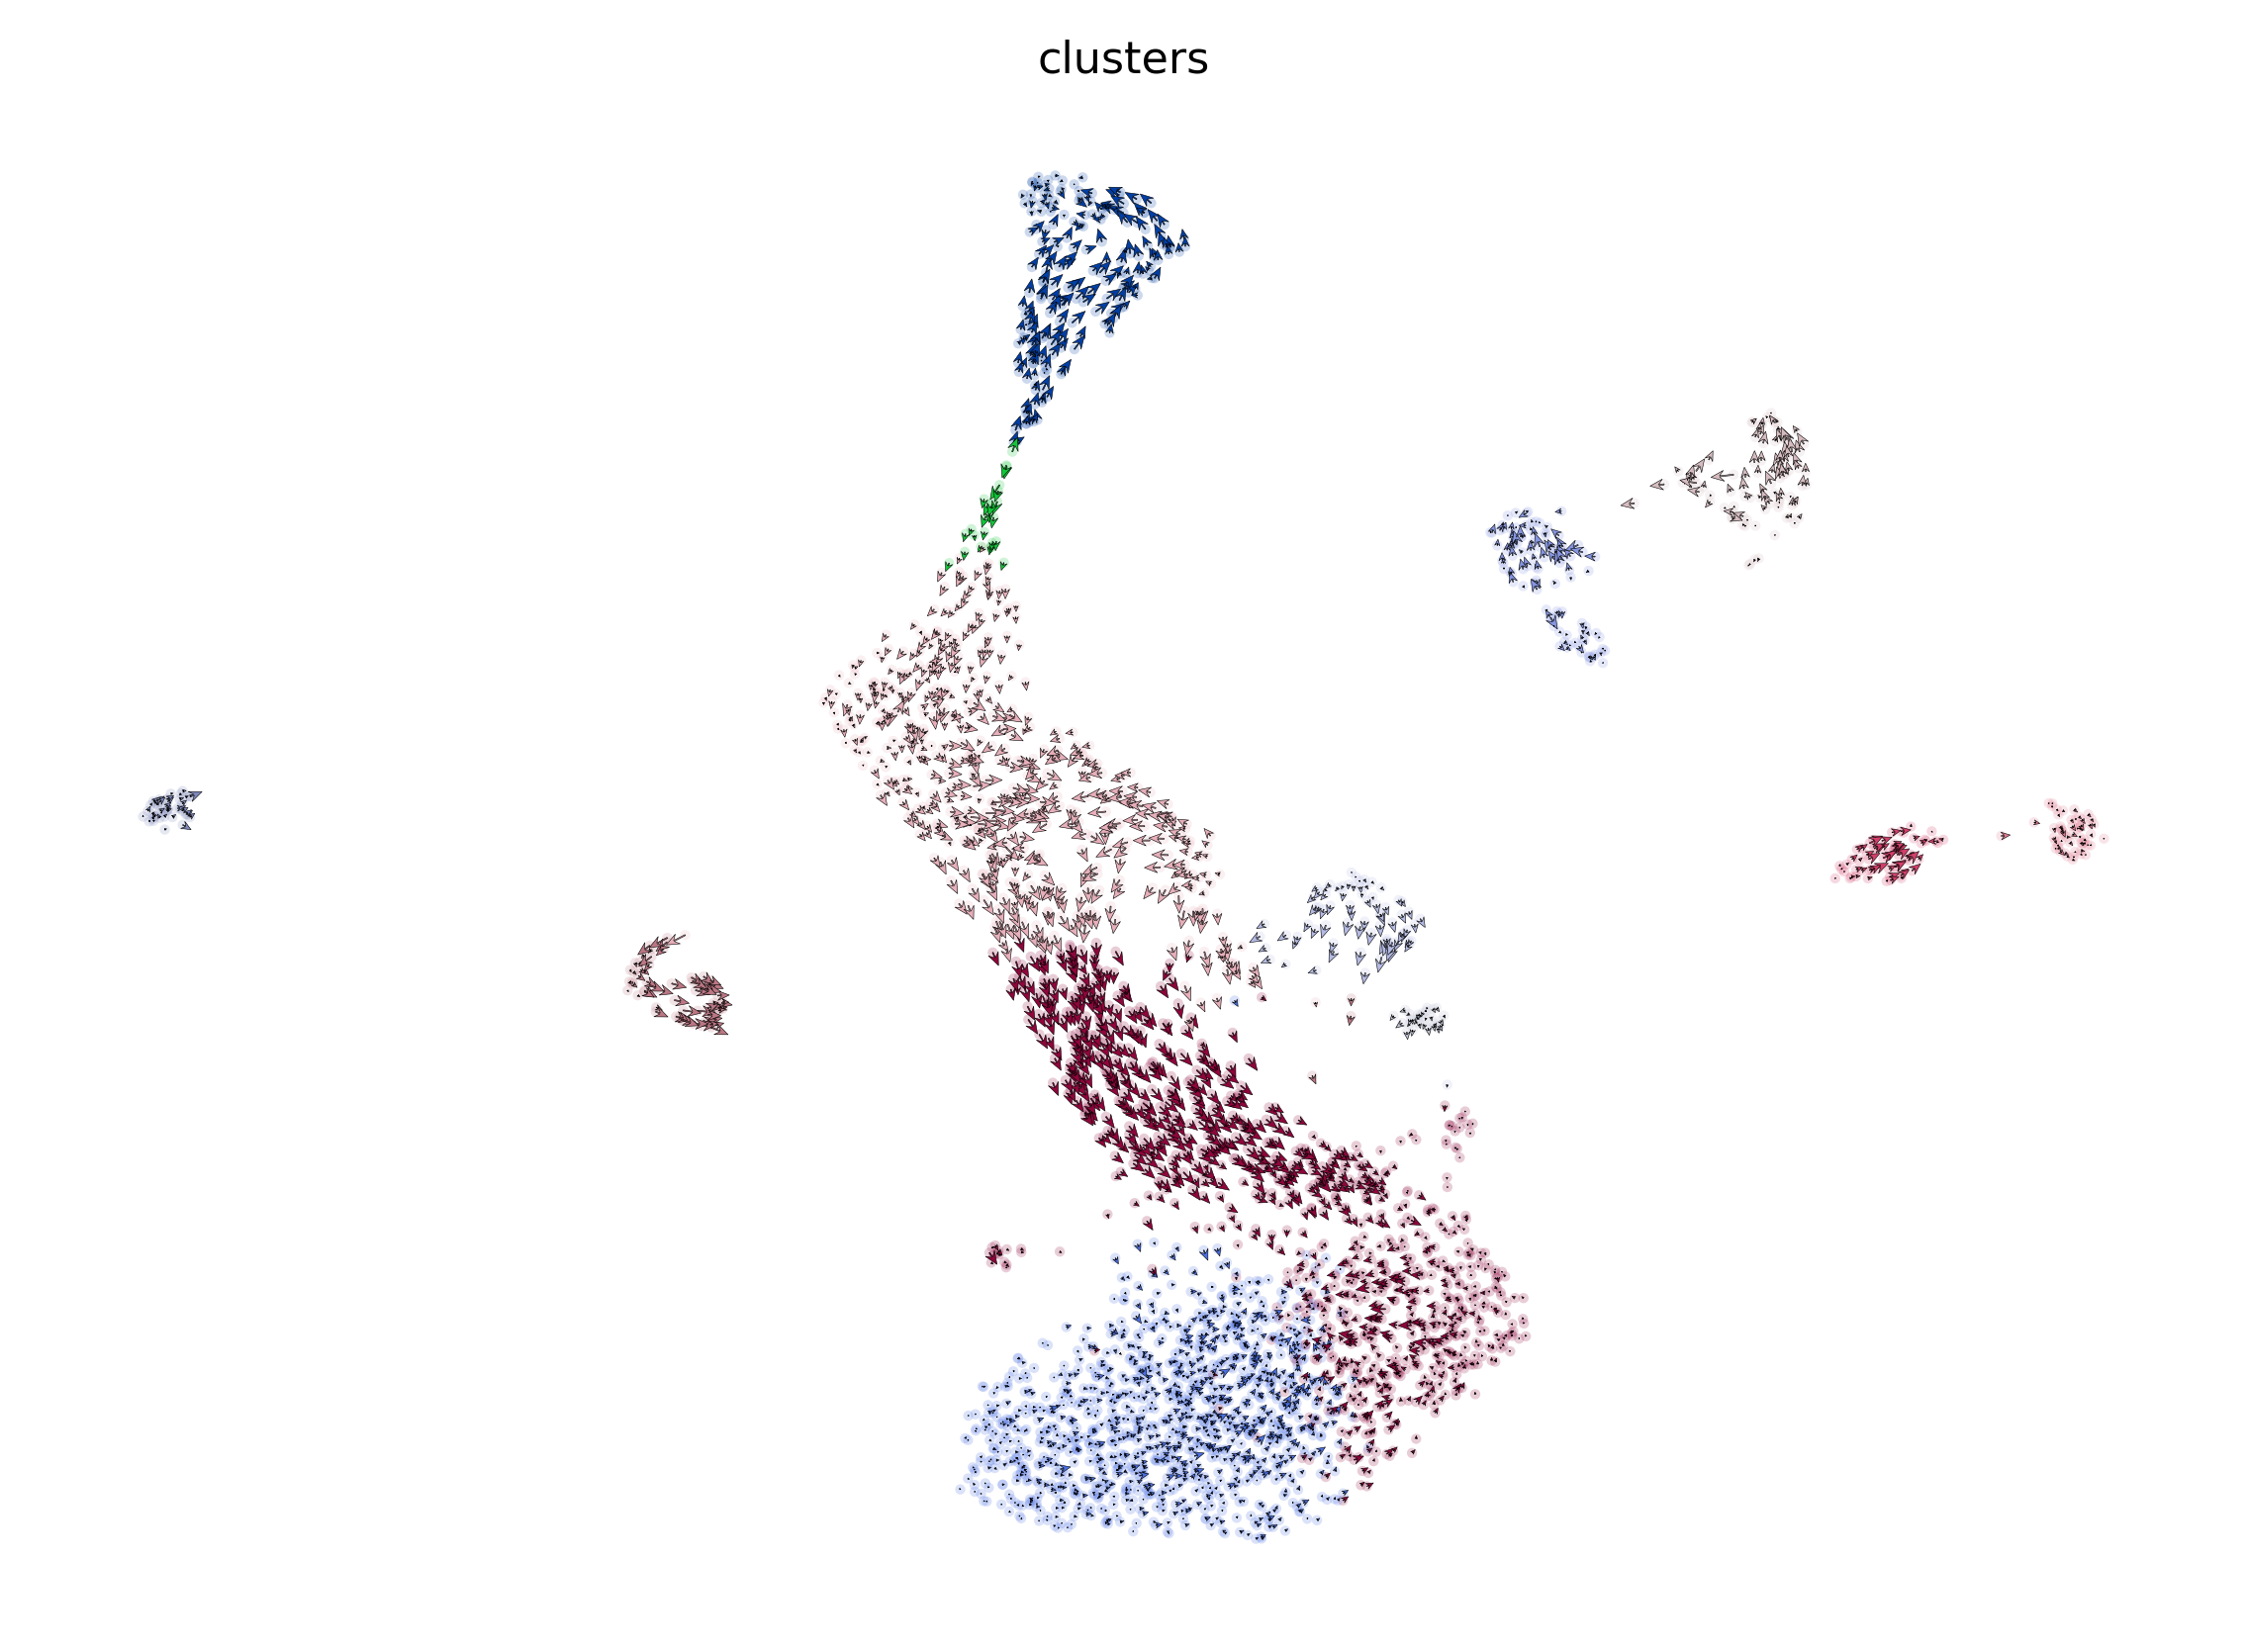

In [25]:
scv.pl.velocity_embedding(adata, basis='umap', dpi=200)

<Figure size 700x500 with 0 Axes>

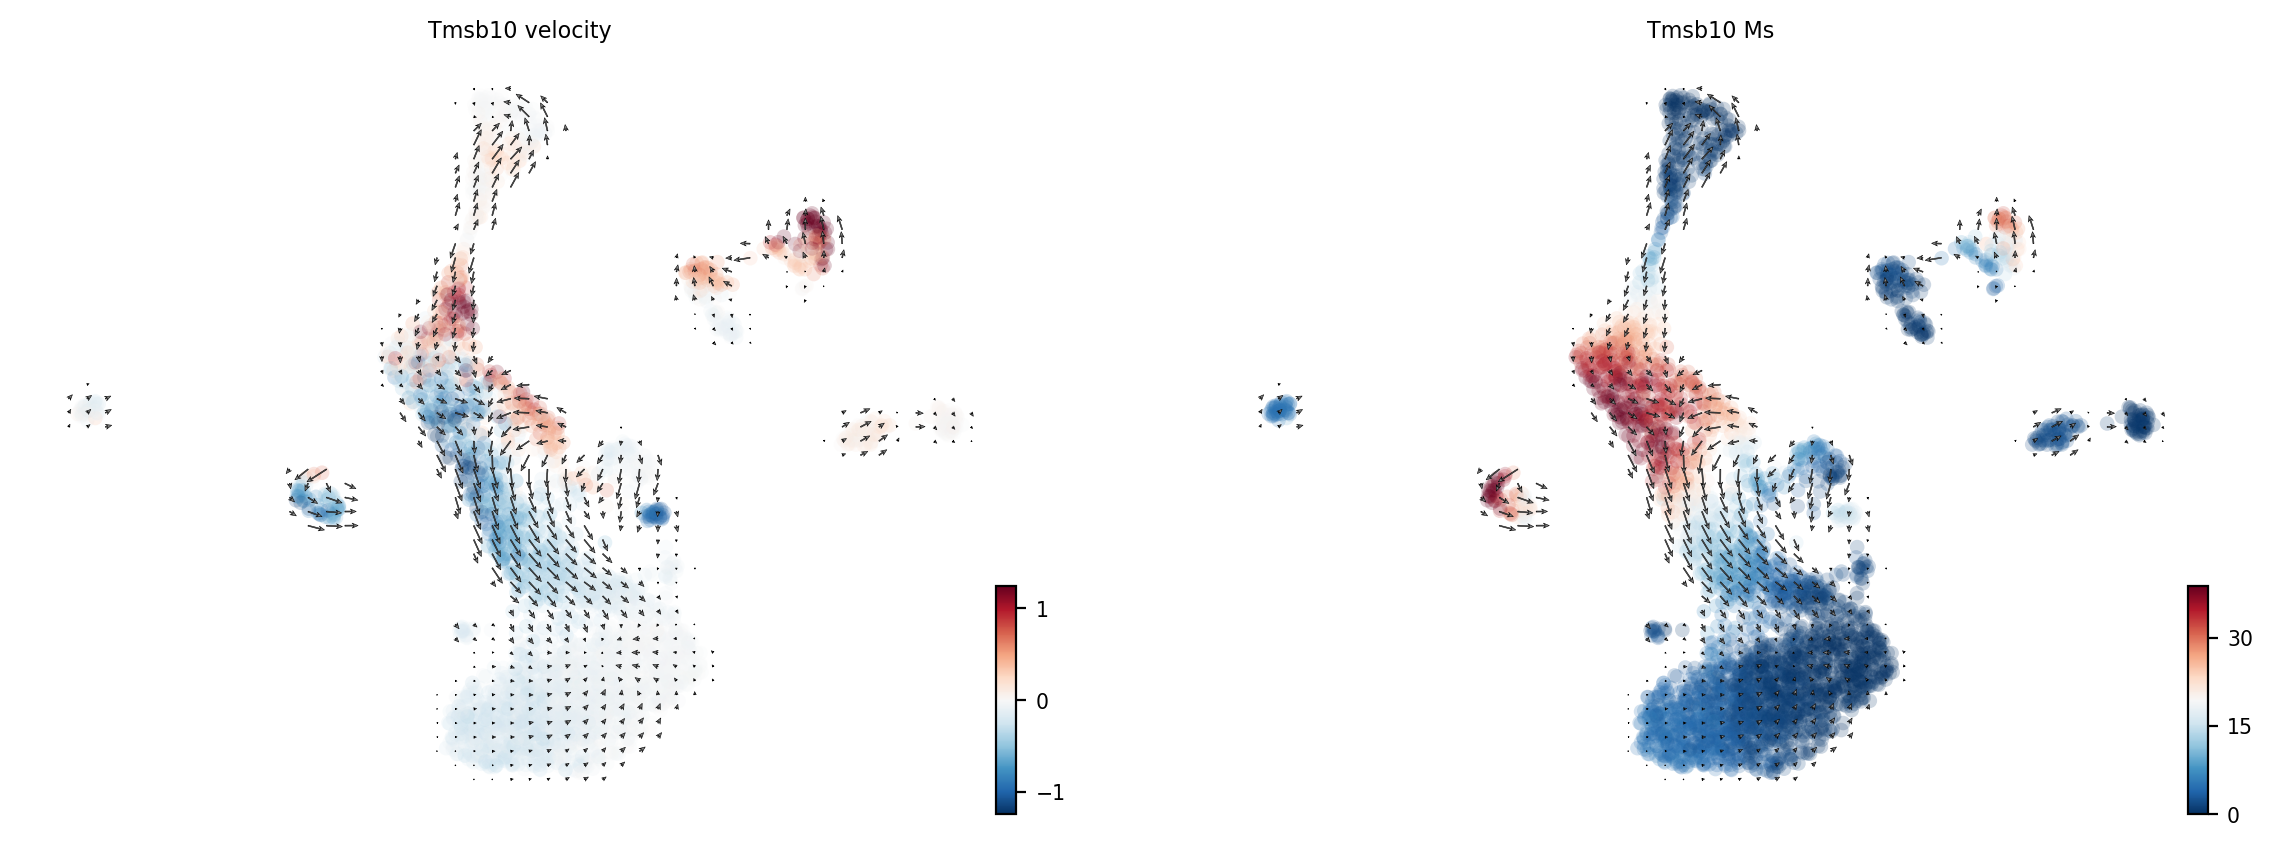

In [26]:
scv.pl.velocity_embedding_grid(adata, color='Tmsb10', layer=['velocity', 'Ms'], colorbar=True)

In [27]:
scv.tl.cell_fate(adata)
scv.tl.terminal_states(adata)

computing cell fates
    finished (0:00:01.85) --> added
    'cell_fate', most likely cell fate (adata.obs)
    'cell_fate_confidence', confidence of transitioning to the assigned fate (adata.obs)
computing terminal states
    identified 0 root cells and 1 end points (Astrocytes)
    identified 1 root cells and 1 end points (Cajal Retzius)
    identified 0 root cells and 0 end points (Cck-Tox)


/Users/yah2014/anaconda3/envs/scanpy/lib/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)
/Users/yah2014/anaconda3/envs/scanpy/lib/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


    identified 1 root cells and 1 end points (Endothelial)
    identified 0 root cells and 1 end points (GABA)
    identified 2 root cells and 1 end points (Granule immature)
    identified 3 root cells and 2 end points (Granule mature)
    identified 0 root cells and 1 end points (Microglia)
    identified 0 root cells and 1 end points (Neuroblast)


IndexError: index 9 is out of bounds for axis 1 with size 9

<Figure size 700x500 with 0 Axes>

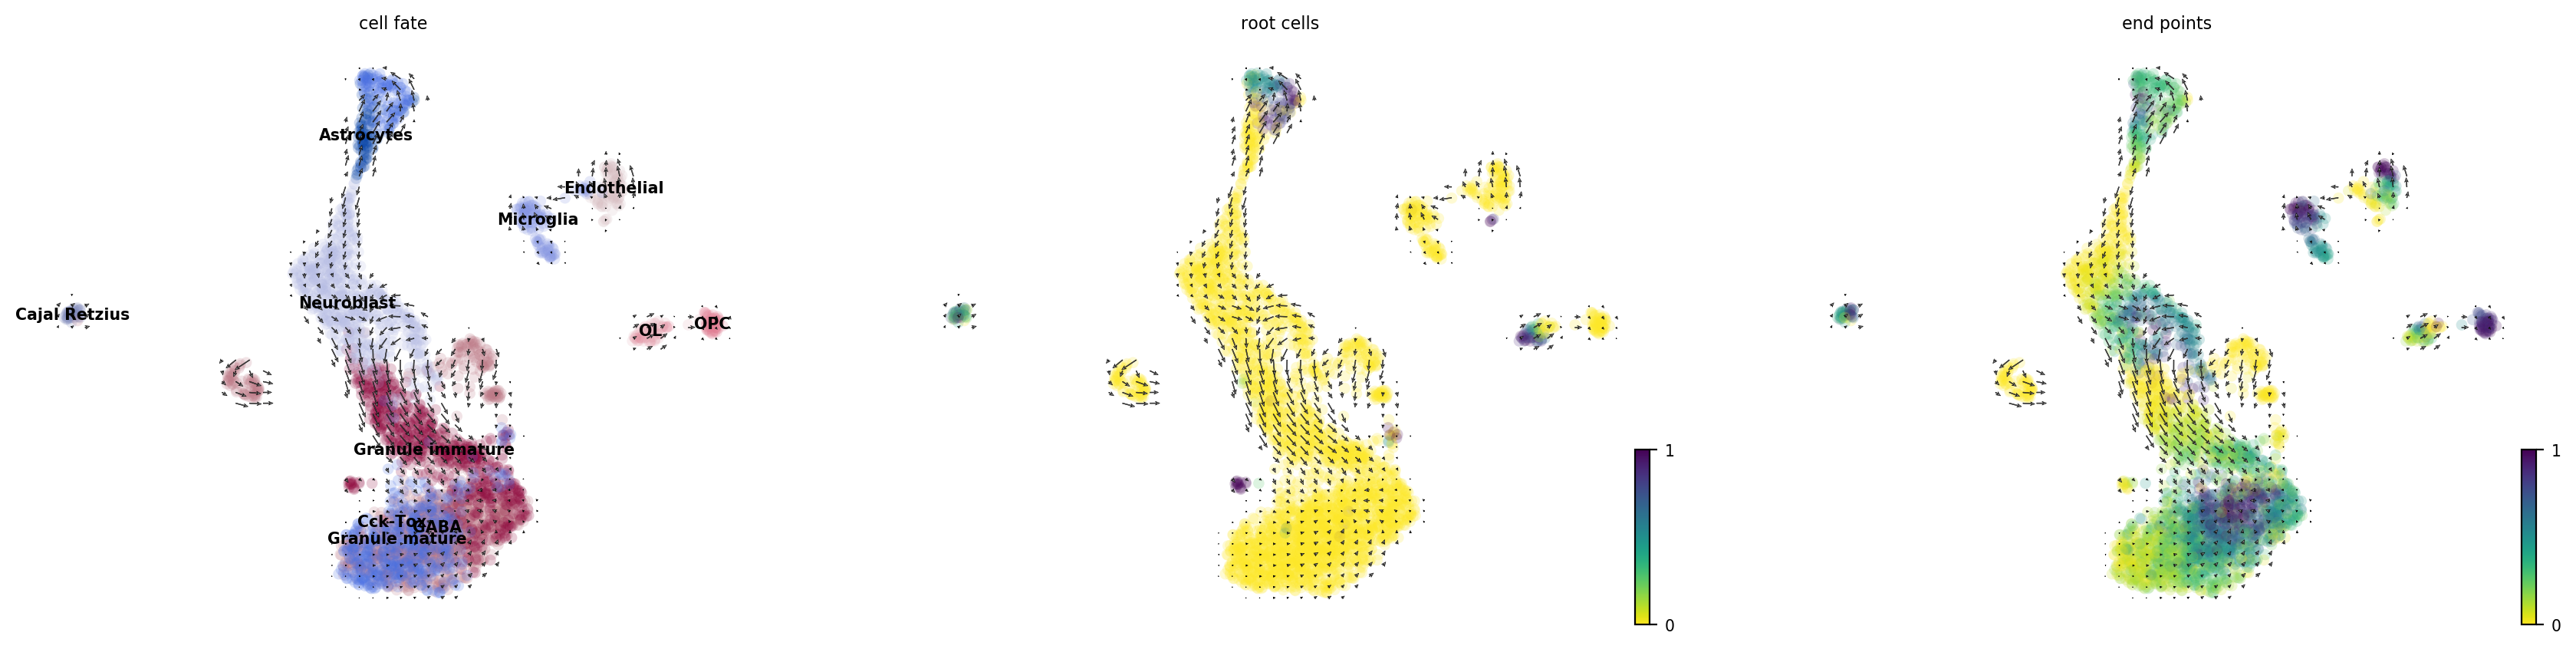

In [28]:
scv.pl.velocity_embedding_grid(adata, color=['cell_fate', 'root_cells', 'end_points'], legend_loc='on data')

In [29]:
scv.tl.rank_velocity_genes(adata, match_with='clusters', resolution=.8)
adata.uns['rank_velocity_genes']['names']

computing velocity clusters


AssertionError: 

ValueError: color key is invalid! pass valid observation annotation or a gene name

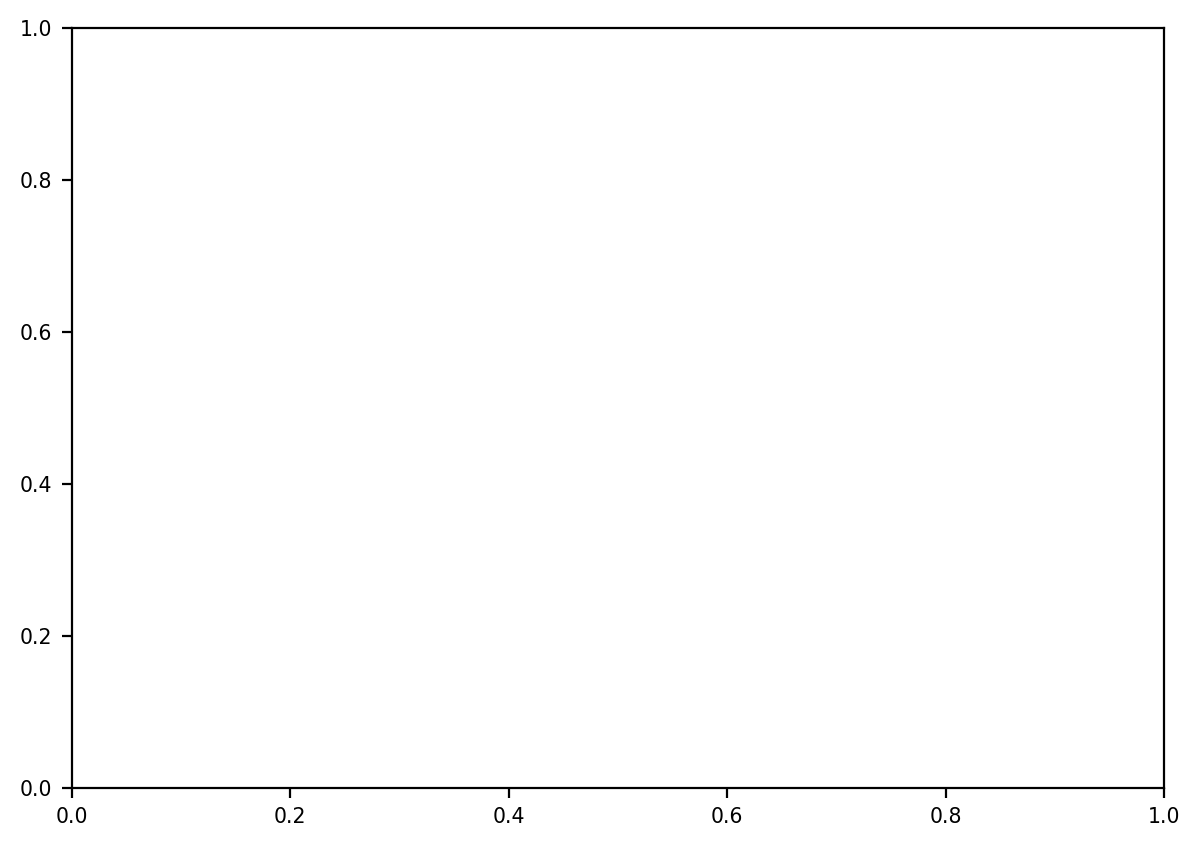

In [30]:
scv.pl.scatter(adata, color='velocity_clusters', legend_loc='on data')

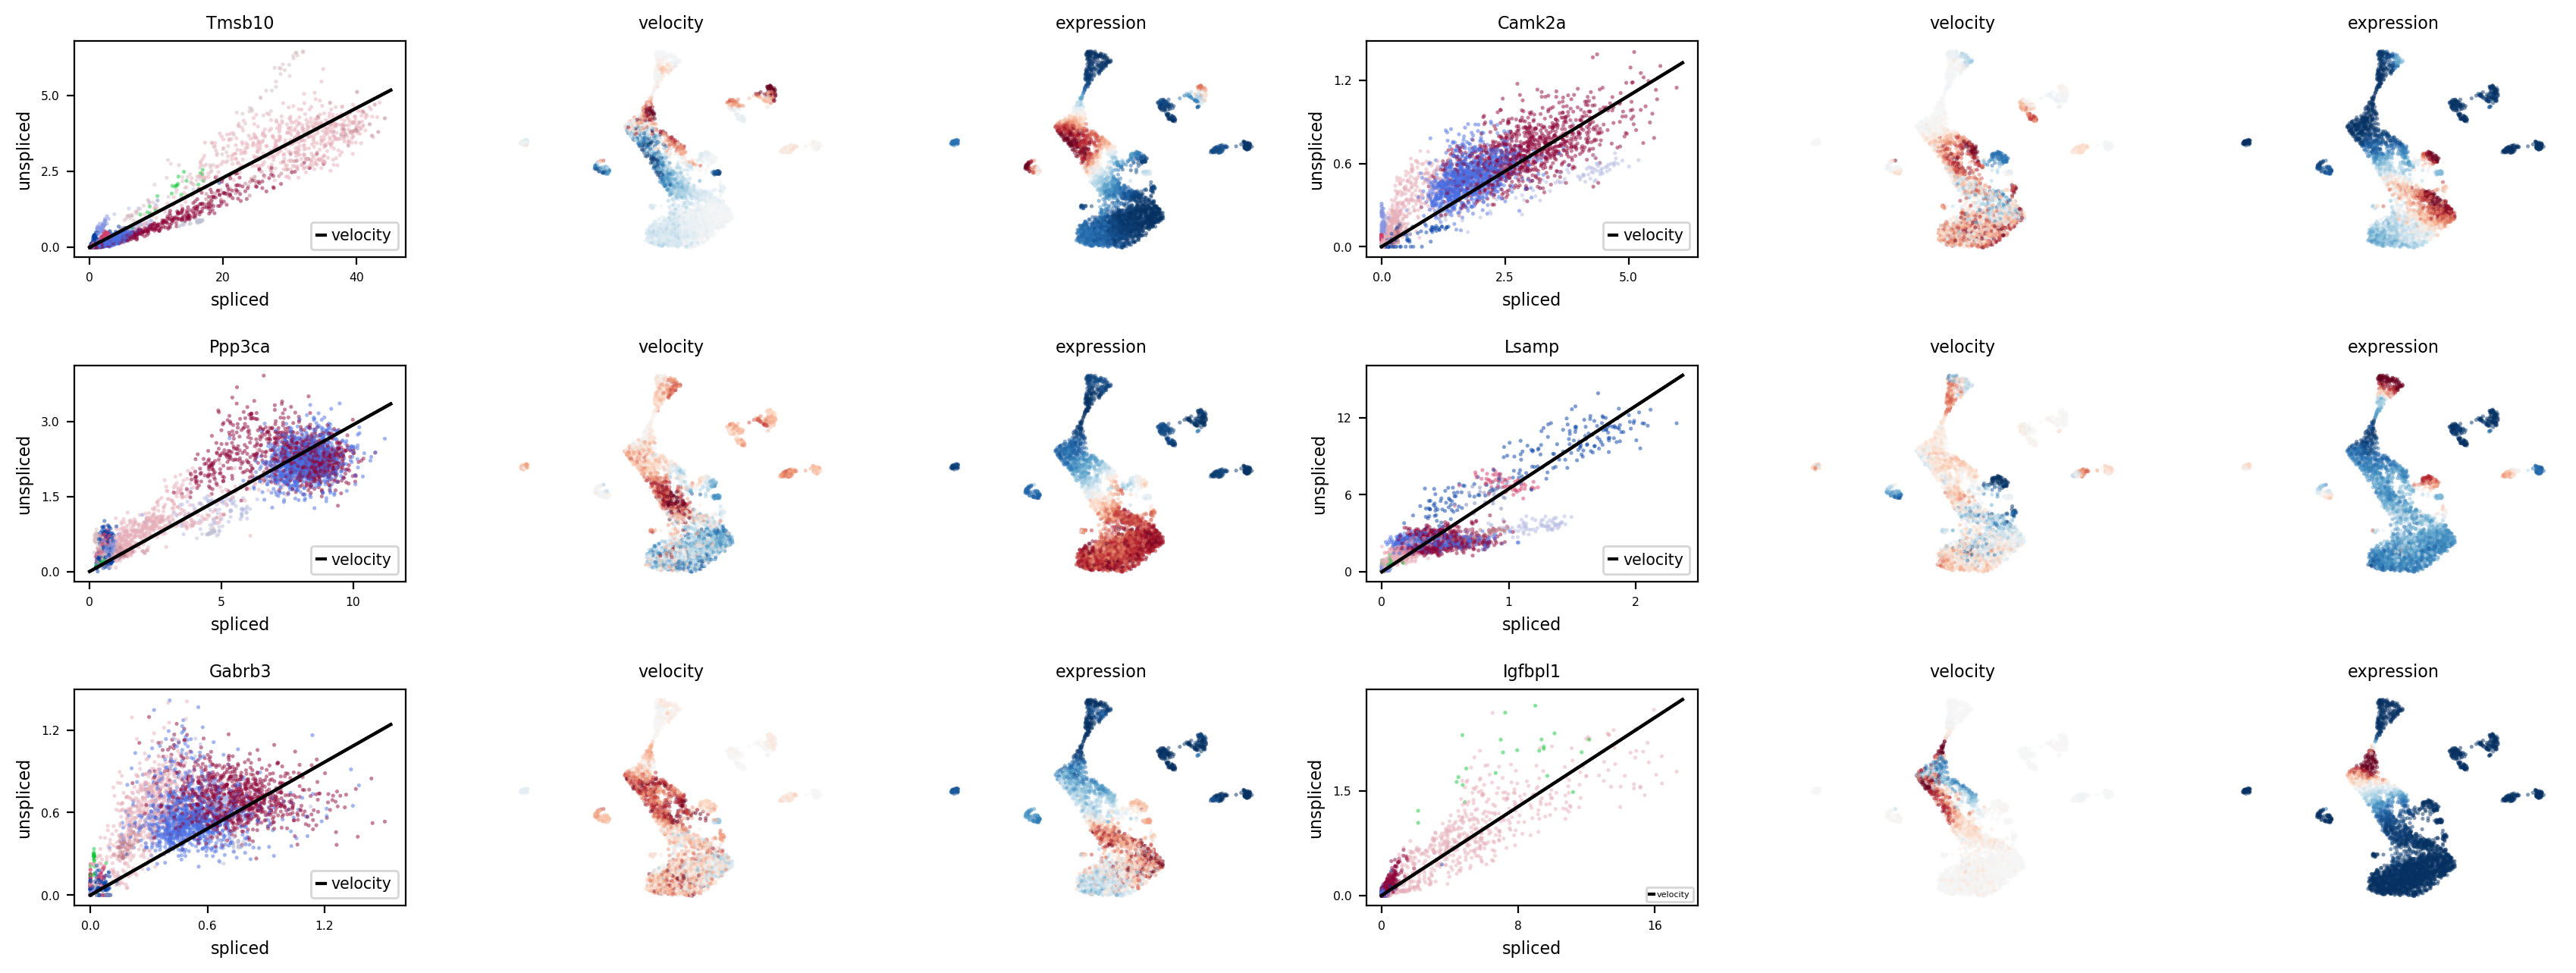

In [31]:
scv.pl.velocity(adata, var_names=['Tmsb10', 'Camk2a', 'Ppp3ca', 'Lsamp', 'Gabrb3', 'Igfbpl1'], ncols=2)

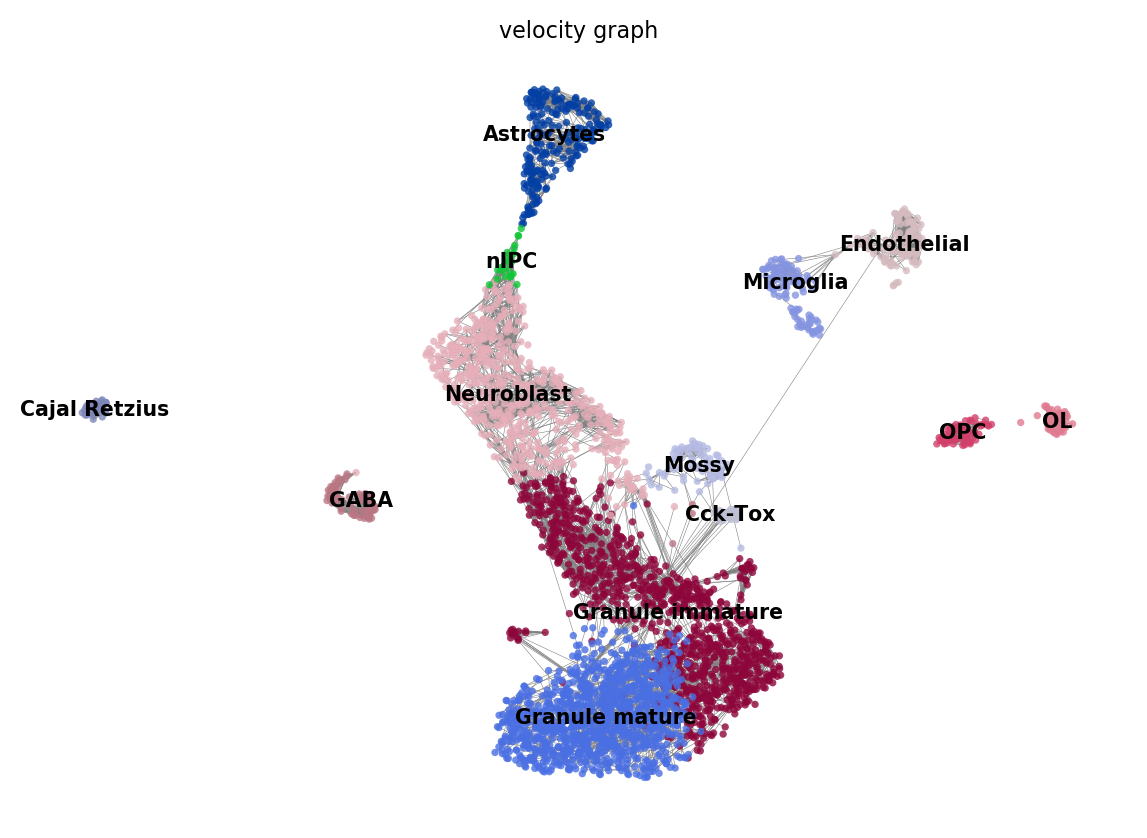

In [32]:
scv.pl.velocity_graph(adata)

In [33]:
scv.tl.paga(adata, groups='clusters')
scv.tl.paga(adata, groups='clusters', use_rna_velocity=True)

/Users/yah2014/anaconda3/envs/scanpy/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


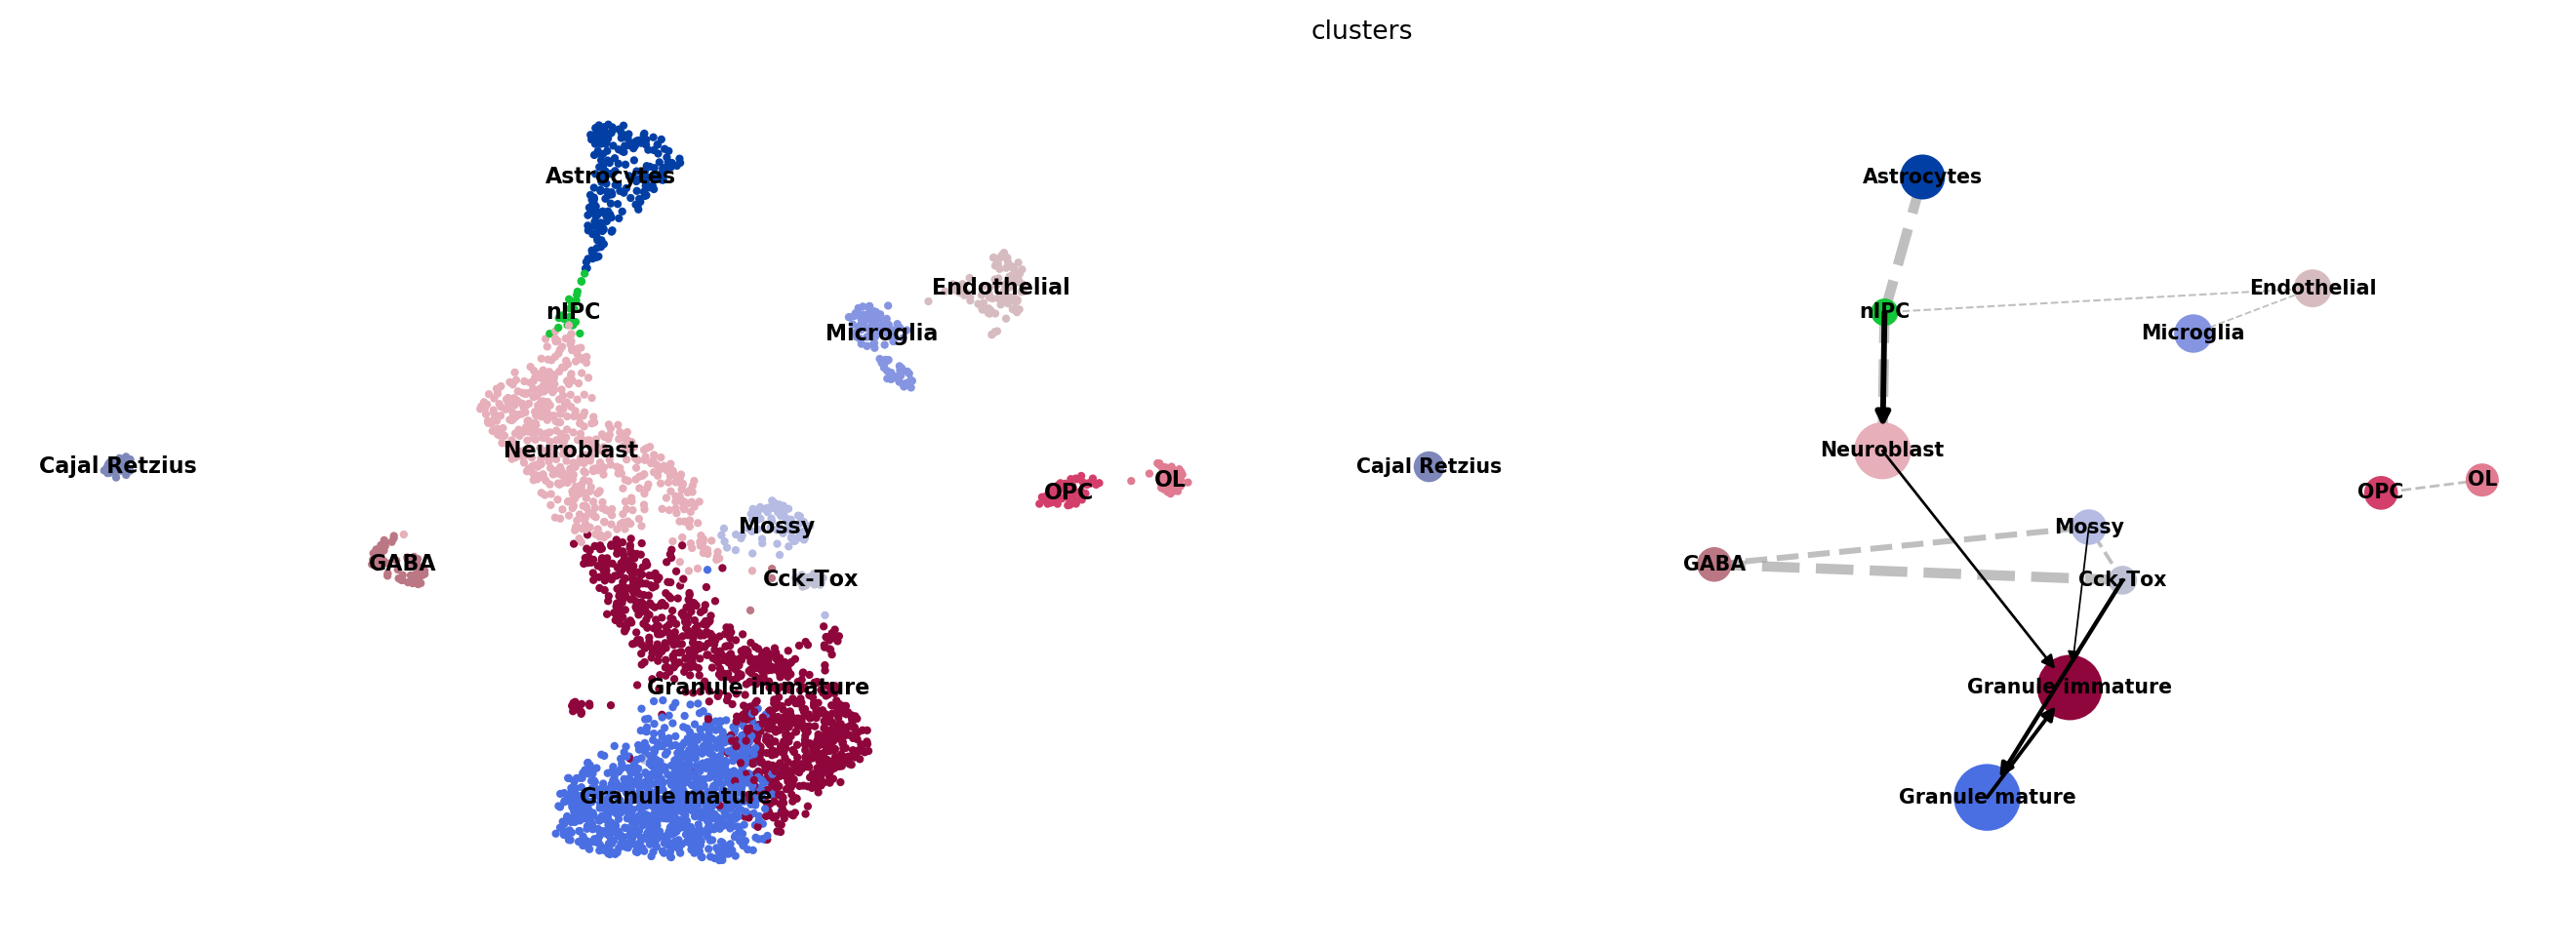

In [34]:
scv.pl.paga_compare(adata, basis='umap', threshold=.15, arrowsize=10, edge_width_scale=.5,
                    transitions='transitions_confidence', dashed_edges='connectivities')